# LAB 2 MOS: Modelado Matematico Avanzado

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 5: Rutas optimas para equipos de inspeccion de infraestructura en Colombia

### Preprocesamiento de datos

In [1]:
import numpy as np
import csv

def read_cost_matrix_csv(filename):
    """
    Lee una matriz de costos desde un archivo CSV y la devuelve como un array de numpy.
    Se asume que la primera fila contiene los IDs de las localidades.

    Parámetros:
        filename (str): Nombre del archivo CSV de entrada.

    Devuelve:
        numpy.ndarray: La matriz de costos leída desde el archivo.
    """
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        node_ids = next(reader)  # Lee los IDs de las localidades (no usado en este caso)
        data = list(reader)  # Lee los datos restantes

    # Convierte los datos a un array de numpy de enteros
    cost_matrix = np.array(data, dtype=int)
    cost_matrix[cost_matrix == 0] = 999

    return cost_matrix

def validate_cost_matrix(cost_matrix):
    """Verifica que la matriz de costos no tenga valores negativos o NaN."""
    if np.any(cost_matrix < 0):
        print("Error: La matriz de costos contiene valores negativos.")
        return False
    if np.any(np.isnan(cost_matrix)):
        print("Error: La matriz de costos contiene valores NaN.")
        return False
    return True

# Leer y validar la matriz de costos
filename = './matrix_cost/cost_matrix_5_nodes_2.5_spread.csv'  # Ajusta el nombre del archivo según tu caso
cost_matrix = read_cost_matrix_csv(filename)

# Verificar la validez de la matriz
if validate_cost_matrix(cost_matrix):
    print("La matriz de costos es válida.")
else:
    print("La matriz de costos no es válida.")

La matriz de costos es válida.


### Formulacion para un unico viajero

#### Conjuntos

Nodos: 
$$ N = \{N1,N_2,...,N_n\}$$
$$ \forall i \in N$$
$$ \forall j \in N$$

#### Parametros

Costos: De ir de i a j
$$ c_{ij}: \forall i\in N, \forall j\in N$$

#### Variables de decision

Tomar el camino de i a j
$$ x_{ij} \in {0,1}$$

Auxiliar para subtours
$$ u_{i} \leq n-1$$


#### Funcion objetivo

$$ MIN(\sum_{i\in N} \sum_{j\in N} x_{ij} \cdot c_{ij})$$

Costo total del viaje (se minimiza)

#### Restricciones

Cada localidad tiene una entrada

$$ \sum_{i\in D, i \neq j} x_{ij} = 1  , \forall j \in N$$

Cada localidad tiene una salida

$$ \sum_{j\in O, i \neq j} x_{ij} = 1 , \forall i \in N$$

No tener autociclos

$$ x_{i,i} = 0, \forall i \in N $$

$$ u_{i} \geq 0$$

Subtours

$$ u_i - u_j + n \cdot x_{ij} \leq n - 1, \forall i, j / i \neq j, i \neq 1, j \neq 1 \in N $$



In [2]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

class Optimization:
    def __init__(self, cost_matrix):
        self.cost_matrix = cost_matrix
        self.num_cities = len(cost_matrix)

    def build_model(self):
        # Crear el modelo
        self.model = pyo.ConcreteModel()

        # Conjuntos
        self.model.N = pyo.RangeSet(1, self.num_cities)

        # Variables de decisión: x[i, j] = 1 si viaja de i a j
        self.model.x = pyo.Var(self.model.N, self.model.N, within=pyo.Binary)

        # Variable auxiliar u[i] para eliminar subtours
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(1, self.num_cities - 1))

        # Parámetro de costos c[i, j]
        def cost_init(model, i, j):
            return self.cost_matrix[i - 1][j - 1]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # Función objetivo: Minimizar el costo total
        def objective_function(model):
            return sum(model.x[i, j] * model.c[i, j]
                       for i in model.N for j in model.N)
        self.model.objective = pyo.Objective(rule=objective_function, sense=pyo.minimize)

        # Restricciones: cada ciudad tiene exactamente una salida
        def outbound_rule(model, i):
            return sum(model.x[i, j] for j in model.N if j != i) == 1
        self.model.outbound = pyo.Constraint(self.model.N, rule=outbound_rule)

        # Restricciones: cada ciudad tiene exactamente una entrada
        def inbound_rule(model, j):
            return sum(model.x[i, j] for i in model.N if i != j) == 1
        self.model.inbound = pyo.Constraint(self.model.N, rule=inbound_rule)

        # Restricción de no auto-ciclos
        def no_self_loops(model, i):
            return model.x[i, i] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, rule=no_self_loops)

        # Restricciones de eliminación de subtours
        def subtour_elimination(model, i, j):
            if i != j and i != 1 and j != 1:
                return model.u[i] - model.u[j] + self.num_cities * model.x[i, j] <= self.num_cities - 1
            else:
                return pyo.Constraint.Skip
        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, rule=subtour_elimination)


    def print_output(self):
        """
        Plots the solution as a directed graph using NetworkX and matplotlib.
        Since there's only one route (single driver), all edges are colored the same.
        """
        valid_edges = []
        for i in self.model.N:
            for j in self.model.N:
                if pyo.value(self.model.x[i, j]) > 0.5:
                    valid_edges.append((i, j))

        # Build a directed graph
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        # Add edges from the solution
        for (i, j) in valid_edges:
            G.add_edge(i, j)

        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos, with_labels=True,
                         node_color='lightblue',
                         edge_color='red',
                         arrows=True)
        plt.axis("off")
        plt.show()



In [3]:
# Crear el modelo
tsp = Optimization(cost_matrix)
tsp.build_model()


In [4]:
solver = pyo.SolverFactory('glpk')
r = solver.solve(tsp.model)


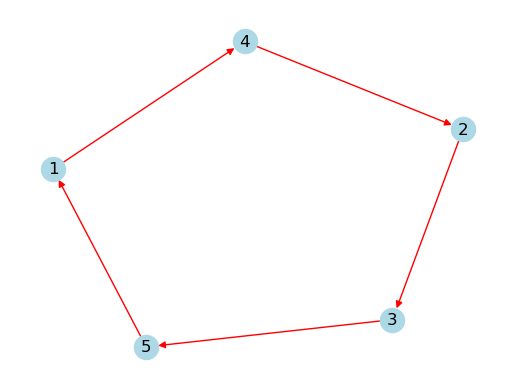


Problem: 
- Name: unknown
  Lower bound: 16.0
  Upper bound: 16.0
  Number of objectives: 1
  Number of constraints: 27
  Number of variables: 29
  Number of nonzeros: 81
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 9
      Number of created subproblems: 9
  Error rc: 0
  Time: 0.0032417774200439453
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [5]:
tsp.print_output()
print(r)


In [6]:
print(tsp.model.objective())

16.0


### Preguntas

- ¿Qué evidencia presenta el resultado obtenido? 
- ¿Es correcto el resultado de la implementación? 

- Es un camino ciclico que pasa por todos los nodos y el reporte final del solver indica óptimo = 16.0, lo que sugiere que sí encontró una solución factible y óptima.
- Esta bien, ya que usa la gran mayoria de de valores minimos de conexion, evitando los mas altos como el (6 y el 4) entre los nodos 5,4 y 3,4, asegurando asi, uno de los posibles caminos de costo minimo.


### Extension a multiples viajeros

#### Conjuntos

Nodos: 
$$ N = \{N1,N_2,...,N_n\}$$
$$ \forall i \in N$$
$$ \forall j \in N$$

#### Parametros

Costos: De ir de i a j
$$ c_{ij}: \forall i\in N, \forall j\in N$$

Numero de viajeros
$$ K $$

#### Variables de decision

Viajero k toma el camino de i a j
$$ x_{ijk} \in {0,1}$$

Auxiliar para subtours
$$ u_{i} \leq n-1$$


#### Funcion objetivo

$$ MIN(\sum_{i\in N} \sum_{j\in N} \sum_{k\in K} x_{ijk} \cdot c_{ij})$$

Costo total del viaje (se minimiza)

#### Restricciones

Cada localidad tiene una entrada

$$ \sum_{i\in D, i \neq j} \sum_{k\in K} x_{ijk} = 1  , \forall j \in N$$

Cada localidad tiene una salida

$$ \sum_{j\in O, i \neq j} \sum_{k\in K} x_{ijk} = 1 , \forall i \in N$$

No tener autociclos

$$ x_{i,i,k} = 0, \forall i \in N \forall k \in K $$

$$ u_{i} \geq 0$$

Subtours

$$ u_i - u_j + n \cdot x_{ijk} \leq n - 1, \forall i, j, k / i \neq j, i \neq 1, j \neq 1 \in N $$

Unicidad de localidad por equipo

$$ \sum_{K\in K} x_{ijk} = 1 , \forall j,i \in N / i \neq j$$



In [7]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


class Optimization2:
    """
    A TSP model for multiple drivers with a depot (city 0) and MTZ subtour elimination.
    """

    def __init__(self, cost_matrix, num_teams):
        self.cost_matrix = cost_matrix
        self.num_cities = len(cost_matrix)
        self.num_teams = num_teams

    def model(self):
        self.model = pyo.ConcreteModel()

        # Cities (including depot at 0)
        self.model.N = pyo.RangeSet(0, self.num_cities - 1)
        # Teams
        self.model.M = pyo.RangeSet(1, self.num_teams)

        # Variables: x[i,j,k] = 1 if team k travels from i to j
        self.model.x = pyo.Var(self.model.N, self.model.N, self.model.M, within=pyo.Binary)

        # MTZ auxiliary variables
        self.model.u = pyo.Var(self.model.N, self.model.M, within=pyo.NonNegativeReals, bounds=(1, self.num_cities - 1))

        # Cost parameter
        def cost_init(model, i, j):
            return self.cost_matrix[i][j]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # Objective: Minimize total travel cost
        def obj_rule(model):
            return sum(model.x[i,j,k] * model.c[i,j] for i in model.N for j in model.N for k in model.M)
        self.model.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

        # Constraints
        def outbound_rule(model, i):
            if i != 0:
                return sum(model.x[i,j,k] for j in model.N for k in model.M if j != i) == 1
            else:
                return pyo.Constraint.Skip
        self.model.outbound = pyo.Constraint(self.model.N, rule=outbound_rule)

        def start_rule(model, k):
            return sum(model.x[0,j,k] for j in model.N if j != 0) == 1
        self.model.start = pyo.Constraint(self.model.M, rule=start_rule)

        def end_rule(model, k):
            return sum(model.x[i,0,k] for i in model.N if i != 0) == 1
        self.model.end = pyo.Constraint(self.model.M, rule=end_rule)

        def mid_rule(model, i, k):
            if i != 0:  # Excluir el nodo de inicio
                return sum(model.x[i, j, k] for j in model.N if j != i) == sum(model.x[j, i, k] for j in model.N if j != i)
            else:
                return pyo.Constraint.Skip

        self.model.mid = pyo.Constraint(self.model.N, self.model.M, rule=mid_rule)

        def mtz_rule(model, i, j, k):
            if i != j and i != 0 and j != 0:
                return model.u[i, k] - model.u[j, k] + (self.num_cities - 1) * model.x[i, j, k] <= self.num_cities - 2
            else:
                return pyo.Constraint.Skip
        self.model.mtz = pyo.Constraint(self.model.N, self.model.N, self.model.M, rule=mtz_rule)

        def no_self_loop_rule(model, i, k):
            return model.x[i,i,k] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, self.model.M, rule=no_self_loop_rule)

    def print_routes(self):
        print("Optimized Routes:")
        for k in self.model.M:
            route = []
            for i in self.model.N:
                for j in self.model.N:
                    if i != j and pyo.value(self.model.x[i, j, k]) == 1:
                        route.append((i, j))
            print(f"Team {k}: {route}")

    def solve_model(self):
        solver = pyo.SolverFactory('glpk')
        result = solver.solve(self.model)
        print(result)
        self.print_routes()

    def print_output(self):
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']
        edge_colors = []
        edge_list = []

        # Inicializar un diccionario con colores por equipo
        team_labels = {k: colors[(k - 1) % len(colors)] for k in self.model.M}

        for k in self.model.M:
            for i in self.model.N:
                for j in self.model.N:
                    if i != j and pyo.value(self.model.x[i, j, k]) == 1:
                        G.add_edge(i, j)
                        edge_list.append((i, j))
                        edge_colors.append(colors[(k - 1) % len(colors)])

        pos = nx.circular_layout(G)

        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

        # Dibujar los arcos con los colores correctos
        nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color=edge_colors, width=2,
                                arrows=True, connectionstyle="arc3,rad=0.2")

        plt.title("Optimized Routes with Depot (0)")
        plt.axis('off')

        # Crear leyenda con los colores de los equipos
        legend_elements = [Line2D([0], [0], color=color, lw=2, label=f'Team {k}')
                          for k, color in team_labels.items()]

        plt.legend(handles=legend_elements, loc="upper left", title="Teams")

        plt.show()




### Casos


*** Procesando archivo: ./matrix_cost/cost_matrix_20_nodes_0.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 1 equipos...

Problem: 
- Name: unknown
  Lower bound: 20.0
  Upper bound: 20.0
  Number of objectives: 1
  Number of constraints: 402
  Number of variables: 419
  Number of nonzeros: 2167
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 37
      Number of created subproblems: 37
  Error rc: 0
  Time: 0.028320789337158203
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 5), (1, 3), (2, 0), (3, 9), (4, 16), (5, 14), (6, 7), (7, 13), (8, 15), (9, 10), (10, 11), (11, 19), (12, 8), (13, 1), (14, 4), (15, 2), (16, 17), (17, 6), (18, 12), (19, 18)]


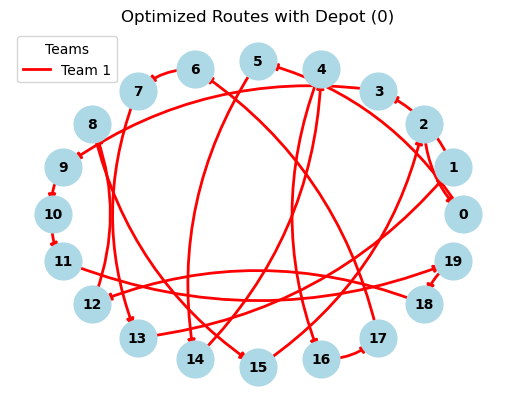


*** Procesando archivo: ./matrix_cost/cost_matrix_5_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 1 equipos...

Problem: 
- Name: unknown
  Lower bound: 16.0
  Upper bound: 16.0
  Number of objectives: 1
  Number of constraints: 27
  Number of variables: 29
  Number of nonzeros: 97
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 9
      Number of created subproblems: 9
  Error rc: 0
  Time: 0.00513148307800293
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 3), (1, 2), (2, 4), (3, 1), (4, 0)]


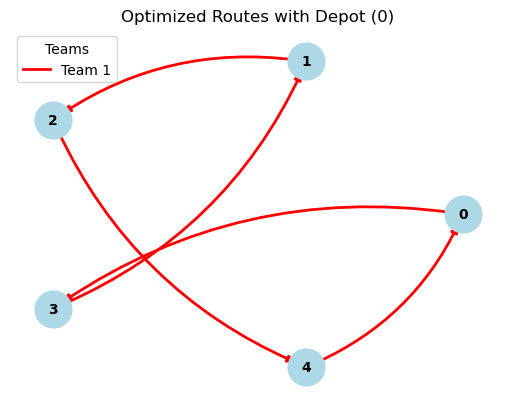


*** Procesando archivo: ./matrix_cost/cost_matrix_15_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 1 equipos...

Problem: 
- Name: unknown
  Lower bound: 37.0
  Upper bound: 37.0
  Number of objectives: 1
  Number of constraints: 227
  Number of variables: 239
  Number of nonzeros: 1177
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 119
      Number of created subproblems: 119
  Error rc: 0
  Time: 0.0901484489440918
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 6), (1, 11), (2, 4), (3, 14), (4, 12), (5, 2), (6, 8), (7, 9), (8, 5), (9, 10), (10, 1), (11, 0), (12, 3), (13, 7), (14, 13)]


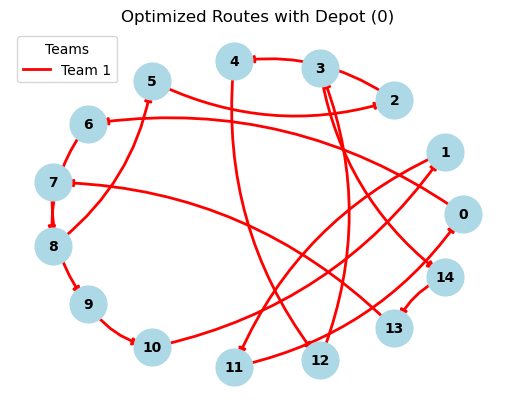


*** Procesando archivo: ./matrix_cost/cost_matrix_10_nodes_1.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 1 equipos...

Problem: 
- Name: unknown
  Lower bound: 16.0
  Upper bound: 16.0
  Number of objectives: 1
  Number of constraints: 102
  Number of variables: 109
  Number of nonzeros: 487
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 41
      Number of created subproblems: 41
  Error rc: 0
  Time: 0.0069122314453125
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 2), (1, 7), (2, 9), (3, 1), (4, 5), (5, 6), (6, 3), (7, 8), (8, 0), (9, 4)]


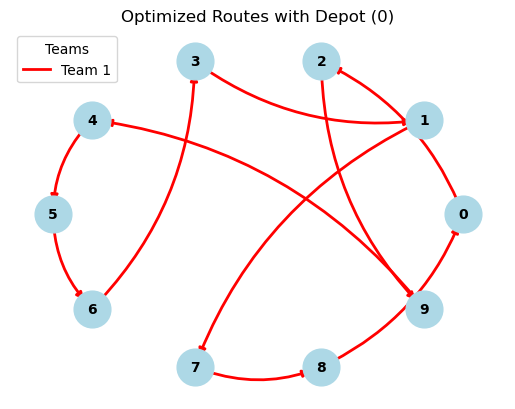

In [8]:
import glob
import os

def run_multi_tsp(folder_path, teams_list):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

    for csv_file in csv_files:
        print(f"\n*** Procesando archivo: {csv_file} ***")
        cost_matrix = read_cost_matrix_csv(csv_file)
        if validate_cost_matrix(cost_matrix):
            print("La matriz de costos es válida.")
        else:
            print("La matriz de costos no es válida.")

        for teams in teams_list:
            print(f"--> Resolviendo con {teams} equipos...")
            tsp = Optimization2(cost_matrix, teams)
            tsp.model()
            tsp.solve_model()
            tsp.print_output()

if __name__ == "__main__":
    run_multi_tsp("./matrix_cost", [1])



*** Procesando archivo: ./matrix_cost/cost_matrix_20_nodes_0.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 2 equipos...

Problem: 
- Name: unknown
  Lower bound: 21.0
  Upper bound: 21.0
  Number of objectives: 1
  Number of constraints: 785
  Number of variables: 838
  Number of nonzeros: 4334
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 51
      Number of created subproblems: 51
  Error rc: 0
  Time: 0.08633112907409668
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 5), (2, 10), (3, 0), (5, 11), (7, 13), (10, 3), (11, 7), (13, 2)]
Team 2: [(0, 14), (1, 4), (4, 15), (6, 1), (8, 12), (9, 6), (12, 17), (14, 18), (15, 8), (16, 19), (17, 16), (18, 9), (19, 0)]


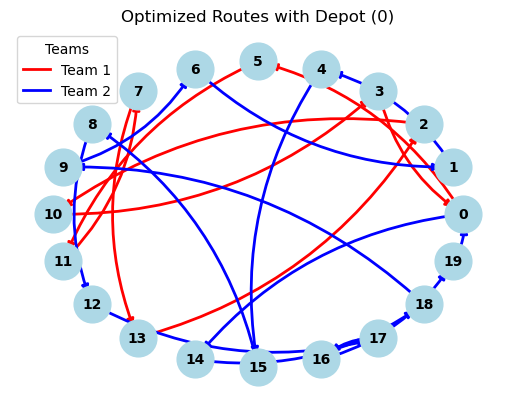


*** Procesando archivo: ./matrix_cost/cost_matrix_5_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 2 equipos...

Problem: 
- Name: unknown
  Lower bound: 18.0
  Upper bound: 18.0
  Number of objectives: 1
  Number of constraints: 50
  Number of variables: 58
  Number of nonzeros: 194
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 7
      Number of created subproblems: 7
  Error rc: 0
  Time: 0.004382610321044922
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 4), (4, 0)]
Team 2: [(0, 1), (1, 3), (2, 0), (3, 2)]


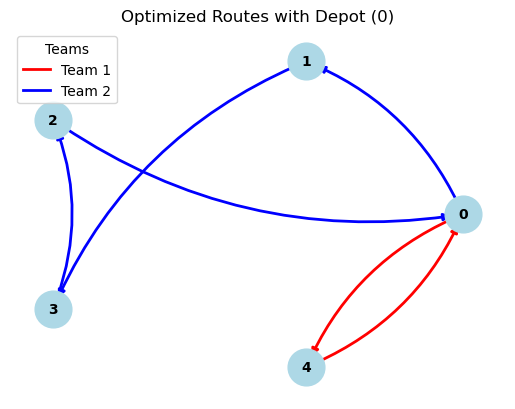


*** Procesando archivo: ./matrix_cost/cost_matrix_15_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 2 equipos...

Problem: 
- Name: unknown
  Lower bound: 37.0
  Upper bound: 37.0
  Number of objectives: 1
  Number of constraints: 440
  Number of variables: 478
  Number of nonzeros: 2354
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1687
      Number of created subproblems: 1687
  Error rc: 0
  Time: 0.9824678897857666
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 6), (6, 0)]
Team 2: [(0, 11), (1, 7), (2, 5), (3, 14), (4, 12), (5, 8), (7, 9), (8, 0), (9, 10), (10, 4), (11, 1), (12, 3), (13, 2), (14, 13)]


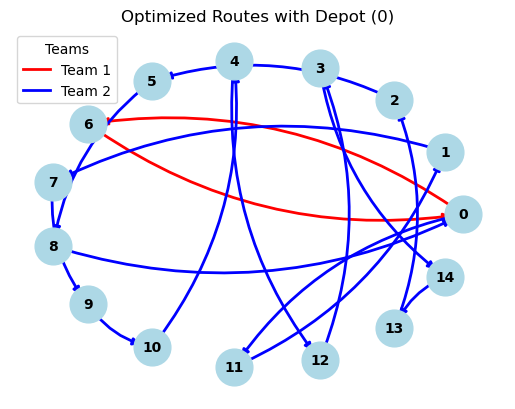


*** Procesando archivo: ./matrix_cost/cost_matrix_10_nodes_1.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 2 equipos...

Problem: 
- Name: unknown
  Lower bound: 17.0
  Upper bound: 17.0
  Number of objectives: 1
  Number of constraints: 195
  Number of variables: 218
  Number of nonzeros: 974
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 31
      Number of created subproblems: 31
  Error rc: 0
  Time: 0.01540684700012207
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 2), (2, 0)]
Team 2: [(0, 8), (1, 3), (3, 6), (4, 9), (5, 4), (6, 5), (7, 1), (8, 7), (9, 0)]


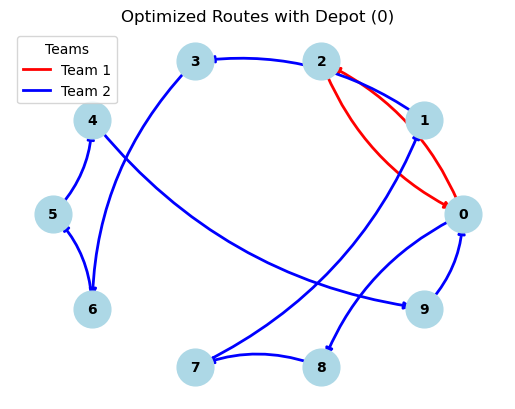

In [9]:
run_multi_tsp("./matrix_cost", [2])


*** Procesando archivo: ./matrix_cost/cost_matrix_20_nodes_0.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 3 equipos...

Problem: 
- Name: unknown
  Lower bound: 22.0
  Upper bound: 22.0
  Number of objectives: 1
  Number of constraints: 1168
  Number of variables: 1257
  Number of nonzeros: 6501
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 95
      Number of created subproblems: 95
  Error rc: 0
  Time: 0.2438509464263916
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 14), (1, 4), (2, 0), (4, 7), (7, 11), (9, 1), (11, 12), (12, 18), (14, 16), (16, 9), (18, 2)]
Team 2: [(0, 13), (8, 10), (10, 17), (13, 8), (17, 0)]
Team 3: [(0, 3), (3, 15), (5, 6), (6, 19), (15, 5), (19, 0)]


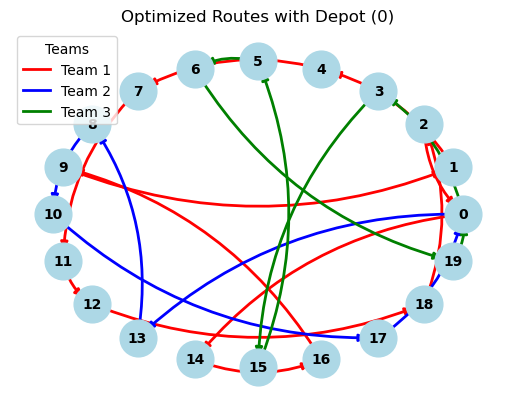


*** Procesando archivo: ./matrix_cost/cost_matrix_5_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 3 equipos...

Problem: 
- Name: unknown
  Lower bound: 21.0
  Upper bound: 21.0
  Number of objectives: 1
  Number of constraints: 73
  Number of variables: 87
  Number of nonzeros: 291
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 3
      Number of created subproblems: 3
  Error rc: 0
  Time: 0.0028142929077148438
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 2), (2, 0)]
Team 2: [(0, 1), (1, 3), (3, 0)]
Team 3: [(0, 4), (4, 0)]


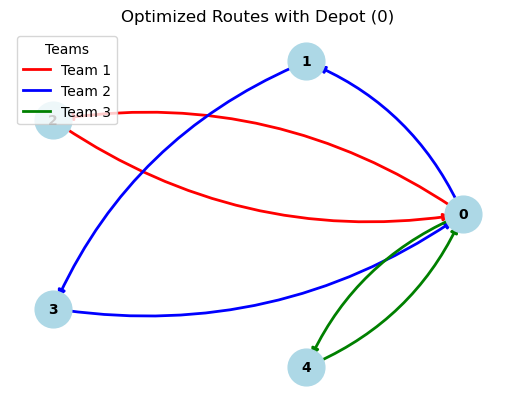


*** Procesando archivo: ./matrix_cost/cost_matrix_15_nodes_2.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 3 equipos...

Problem: 
- Name: unknown
  Lower bound: 39.0
  Upper bound: 39.0
  Number of objectives: 1
  Number of constraints: 653
  Number of variables: 717
  Number of nonzeros: 3531
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1369
      Number of created subproblems: 1369
  Error rc: 0
  Time: 1.2657196521759033
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 6), (6, 0)]
Team 2: [(0, 8), (8, 0)]
Team 3: [(0, 11), (1, 10), (2, 5), (3, 12), (4, 2), (5, 0), (7, 14), (9, 7), (10, 9), (11, 1), (12, 4), (13, 3), (14, 13)]


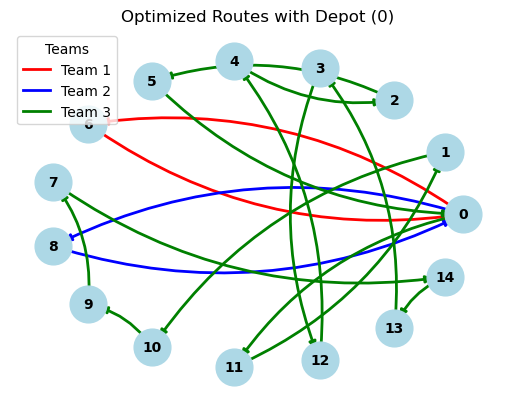


*** Procesando archivo: ./matrix_cost/cost_matrix_10_nodes_1.5_spread.csv ***
La matriz de costos es válida.
--> Resolviendo con 3 equipos...

Problem: 
- Name: unknown
  Lower bound: 20.0
  Upper bound: 20.0
  Number of objectives: 1
  Number of constraints: 288
  Number of variables: 327
  Number of nonzeros: 1461
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 93
      Number of created subproblems: 93
  Error rc: 0
  Time: 0.051235198974609375
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Optimized Routes:
Team 1: [(0, 9), (3, 6), (4, 3), (5, 0), (6, 5), (9, 4)]
Team 2: [(0, 2), (2, 0)]
Team 3: [(0, 1), (1, 7), (7, 8), (8, 0)]


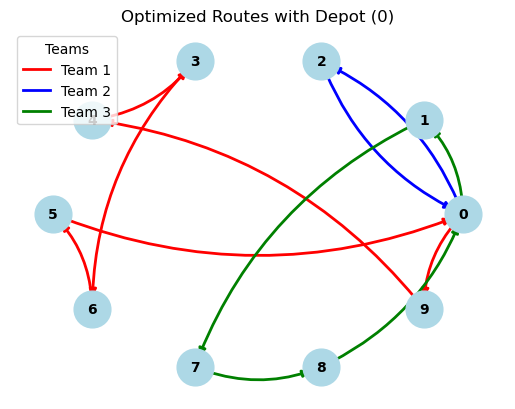

In [10]:
run_multi_tsp("./matrix_cost", [3])


## Conclusion y comparacion

In [14]:
from tabulate import tabulate
headers = ["Nodos", "1 Equipo", "2 Equipos", "3 Equipos"]

datos = []
datos.append([5,16,18,21])
datos.append([10,16,17,20])
datos.append([15,37,37,39])
datos.append([20,20,21,22])

table = tabulate(datos, headers, tablefmt='grid')
print(table)

+---------+------------+-------------+-------------+
|   Nodos |   1 Equipo |   2 Equipos |   3 Equipos |
+=========+============+=============+=============+
|       5 |         16 |          18 |          21 |
+---------+------------+-------------+-------------+
|      10 |         16 |          17 |          20 |
+---------+------------+-------------+-------------+
|      15 |         37 |          37 |          39 |
+---------+------------+-------------+-------------+
|      20 |         20 |          21 |          22 |
+---------+------------+-------------+-------------+


Por limitaciones computacionales, no fue posible ejecutar los grafos más grandes de 50 y 100 nodos. Por ende, el tamaño más grande que el modelo logró resolver fue de 20 nodos.

Como se evidencia en la tabla anterior, se probaron diferentes configuraciones en relación con la cantidad de equipos asignados para realizar las inspecciones. Específicamente, se experimentó con configuraciones de 1, 2 y 3 equipos.

Los resultados indican que, al incrementar el número de equipos, aumenta también el costo total del recorrido. Por ejemplo, en el caso de 5 nodos, el costo fue de 16 con un solo equipo, incrementando a 18 y 21 al usar 2 y 3 equipos, respectivamente. Se observa una tendencia similar para el caso de 10, donde con 1 equipo el costo es 16, incrementándose hasta 20 cuando se usan 3 equipos.
